In [ ]:
import numpy as np
%tensorflow_version 2.x

import matplotlib.pyplot as plt
import scipy.ndimage
import skimage.transform
import random
import tensorflow as tf
import cv2
import os
import glob
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Feauture Visualization with Nudged Elastic Band Methods
Implementation of Feature Visualization and an nudgend elastic band algorithm to produce videos

In [ ]:
#@title Choose which network to use { form-width: "500px" }
model_name = "MobileNetV2" #@param ["MobileNetV2", "InceptionV3"]
model_func = "tf.keras.applications." + model_name + "(include_top=True, weights='imagenet')"
model = eval(model_func)
#model_V3 = tf.keras.applications.InceptionV3(include_top=True, weights='imagenet')
# 

- Inception V3 
    - shape 299, 299,3
    - -1 to 1
- Mobile Net
    - shape 224, 224, 3
    - -1 to 1

In [ ]:
model.trainable = False
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

## Feature Visualization

### Some Support Functions

In [ ]:
def l1_regularization(img,l = 0.005):
   return tf.convert_to_tensor(l * tf.math.reduce_sum(tf.math.abs(img)), dtype=tf.float32) 


def sigmoid(x):
   return 1/(1+np.exp(-x))

def jitter(img, jitter):
    img = tf.convert_to_tensor(img)
    img_shp = tf.shape(img)
    crop_shape = tf.concat([img_shp[:-3], img_shp[-3:-1] - jitter, img_shp[-1:]], 0)
    crop = tf.image.random_crop(img, crop_shape)
    shp = img.get_shape().as_list()
    mid_shp_changed = [
        shp[-3] - jitter if shp[-3] is not None else None,
        shp[-2] - jitter if shp[-3] is not None else None,
    ]
    crop.set_shape(shp[:-3] + mid_shp_changed + shp[-1:])
    return crop


 

def random_jitter(img, max_jitter):
    direction = random.choice(np.arange(0,4))
    amount = random.choice(np.arange(1,max_jitter+1))
    x,y,_ = img.shape
    new_img = np.zeros(img.shape, dtype=np.float32)
     
    if direction == 0:
        #down
        new_img[0:x-amount-1,:,:] = img[amount:x-1,:,:]
        new_img[x-amount-1:x-1,:,:] = 0 #img[x-1,:,:]
    if direction == 1:
        #up
        new_img[amount:x-1,:,:] = img[0:x-amount-1,:,:]
        new_img[0:amount,:,:] = 0 #img[0,:,:]
    if direction == 2:
        #right
        new_img[:,0:y-amount-1:,:] = img[:,amount:y-1,:]
        new_img[:,y-1,:] = 0 #img[:,y-1,:]
    if direction == 3:
        #left
        new_img[:,amount:y-1,:] = img[:,0:y-amount-1,:]
        new_img[:,0:amount,:] =  0 #img[:,,:]
    return tf.convert_to_tensor(new_img)

def random_scale(img, factors):
    #factor = random.choice(factors)
     
    #scaled = skimage.transform.rescale(img, factor)
    #resized = skimage.transform.resize(scaled,img.shape)
    #return tf.convert_to_tensor(resized) #, anti_aliasing=downsampling))

    img = tf.expand_dims(tf.convert_to_tensor(img),0)
    factor = random.choice(factors)
    shp = tf.shape(img)
    scale_shape = tf.cast(factor * tf.cast(shp[-3:-1], "float32"), "int32")
    return tf.squeeze(tf.compat.v1.image.resize_bilinear(img, scale_shape))
 
 

def random_rotate(img, degrees):
    angle = random.choice(degrees)
    angle = (360 + angle) % 360
    return scipy.ndimage.rotate(img, angle=angle, reshape=False, mode='wrap')

#def random_rotate(img, degrees):
#    print(tf.shape(img))
#    return tf.keras.preprocessing.image.random_rotation(img, 5, row_axis=1, col_axis=2, channel_axis=3)




In [ ]:

def normalize_image(img):
    img = np.asarray(img,dtype=np.float32)
    return 2*(img - img.min()) / (img.max() - img.min()) - 1

def pixel_image(shape,sd=1, pixel_format='centered', init_val=None):
    if init_val != None:
        rnd_img = np.full(shape, init_val)
    else:
        rnd_img = np.random.normal(scale=1,size=shape)
    rnd_img = rnd_img.astype(np.float32)
    rnd_img = tf.nn.sigmoid(rnd_img)
    if pixel_format=='centered':
        rnd_img = (rnd_img-0.5)*2.0
    rnd_img = tf.convert_to_tensor(rnd_img,dtype=np.float32)
    return tf.Variable(rnd_img, trainable=True)


# another tr function to fool around with
def transformation_robustness_test(img):
    # pad with 16 pixels
    img = tf.squeeze(img)
    x,y,_ = img.shape
    img = tf.pad(img, tf.constant([[6, 6,], [6, 6], [0, 0]]), "SYMMETRIC")
    # jitter with up to 8 pixels
    img = jitter(img,3)
    
    # scale with a random factor
    #img = random_scale(img, [1 + (i - 5) / 50. for i in range(11)]) # 0.9 - 1.1
    
    # rotate with random angle

    img = random_rotate(img,list(range(-10, 11)) + 5 * [0])
    # jitter up to 4 pixels
    img = jitter(img,3)

    x_2, _, _ = tf.shape(img)
    
    if x_2 < x:
        x_pad = int((x-x_2)/2)
        f_x = 0
        if (x-x_2)%2 == 1:
            f_x = 1
        
        img = tf.pad(img, tf.constant([[x_pad + f_x, x_pad], [x_pad + f_x, x_pad], [0, 0]]), "SYMMETRIC")
    else:
        img = tf.image.resize_with_crop_or_pad(img, x, y)
        #img = tf.image.random_crop(img, (x,y,3))


    #img = tf.image.crop_to_bounding_box(img, offset_height = 12, offset_width=12, target_height=x, target_width=y)
    return img


def transformation_robustness(img):
    # pad with 16 pixels
    img = tf.squeeze(img)
    x,y,_ = img.shape
    img = tf.pad(img, tf.constant([[6, 6,], [6, 6], [0, 0]]), "SYMMETRIC")
    # jitter with up to 8 pixels
    img = jitter(img,3)
    
    # scale with a random factor
    img = random_scale(img, [1.025, 1.01, 0.975, 0.99, 1, 1, 1, 1]) # 0.9 - 1.1
    # rotate with random angle

    img = random_rotate(img,list(range(-3, 4)) + 5 * [0])
    # jitter up to 4 pixels
    img = itter(img,3)

    x_2, _, _ = tf.shape(img)
    if x_2 < x:
        x_pad = int((x-x_2)/2)
        f_x = 0
        if (x-x_2)%2 == 1:
            f_x = 1
        
        img = tf.pad(img, tf.constant([[x_pad + f_x, x_pad], [x_pad + f_x, x_pad], [0, 0]]), "SYMMETRIC")
    else:
        img = tf.image.resize_with_crop_or_pad(img, x, y)


    #img = tf.image.crop_to_bounding_box(img, offset_height = 12, offset_width=12, target_height=x, target_width=y)
    return img


def scale_image(img):
    img = tf.squeeze(img)
    x, y, _ = tf.shape(img)
    img = random_scale(img, [1.5])
    return tf.expand_dims(tf.image.resize_with_crop_or_pad(img, x, y), 0)







### Algorithm for Image Optimization
A random input image is optimized towards activating a chosen feature map. Different regularizations techniques to improve image quality can be selected.


In [1]:
def optimize_image(model, layer, unit, shape, lr=0.05, steps=512, total_variation=None, l1=None, blur=None, blur_step=1, blur_gradient=False, init_val=None, transformation=True, transformation_steps=1, use_optimizer=True, plot=False, plot_step = 100):
    """ Optimizes a random image to maximally activate the chosen unit of the chosen featuremap using gradient ascent

    Parameters
    ----------
    model: tf.keras.Model
        The Model to visualize
    layer: str
        the name of the layer: only needed for plotting
    unit: int
        unit of the layer: only needed for plotting
    shape: tuple
       shape of input (batch, height, width, channels)
    lr: float
        learning rate
    steps: int
        number of optimization steps
    total_variation: float
        scaling for total variation penatly
    l1: float
        scaling for l1 penatly
    blur: boolean
        one of 'gaussian' or 'bilateral'
    blur_step: int
        image gets blurred every blur_step steps
    blur_gradient:
        if trues uses gaussian to blur gradient
    init_val: int
        initial pixel value for image
    transformation: boolean
        if true applies transformation robustness 
    transforformation_steps: int
        apply transformations every transformation_steps step
    use_optimizer: boolean
        if True uses Adam, if False standard gradient descent
    plot: boolean
        if True plot intermediate images
    plot steps:
        step size for intermediat results
 
    returns
    -------
    img: tf.tensor
        optimized image

    """

    tf.keras.backend.clear_session()
   
     
 

    if use_optimizer:
        optimizer = tf.optimizers.Adam(lr)
  
 
    img = pixel_image(shape, init_val=init_val)
     

    
    # Update loop.
    average_activations = []
    plot_imgs = []
    steps_ar = []


    
  
    for step in range(steps):

        if transformation and step%transformation_steps == 0:
            img = tf.Variable(transformation_robustness(img))
            img = tf.expand_dims(img,0)

        #if step in [100,150,200,250,300,350,400]:
         #   img = tf.Variable(scale_image(img))
            



        with tf.GradientTape() as tape:
            tape.watch(img)
            # The gradient tape will not care about the image, because usually it is not a variable.
            # GradientTape has a method called 'watch', which can be used here.

             
            ######################
            #tape.watch(img)

            # Feed the image (remember to add batch dimension) to the model and compute the
            # average activation of the feature map. To get the average use 'tf.reduce_mean'.
            out_fm = visualization_model(img)
             
            average_activation = tf.reduce_mean(out_fm)
            # l1 or total cariation as penalty
            if total_variation != None:
                regularization_penalty = tf.image.total_variation(img) * total_variation
            elif l1 != None:
                regularization_penalty = l1_regularization(img, l=l1) 
            else:
                regularization_penalty = 0
 
            regularized_activity = average_activation - regularization_penalty 


            
            ######################
            
            # Compute the gradients to maximize the average activation in respect to the image.
            if use_optimizer:
                gradients = tape.gradient(-regularized_activity, img)
            else:
                gradients = tape.gradient(regularized_activity, img)
     
            ######################
        
        if blur_gradient:
            gradients = cv2.GaussianBlur(np.asarray(tf.squeeze(gradients)),(7,7), 1)
            gradients = tf.expand_dims(tf.convert_to_tensor(gradients),0)
             

        # Normalize gradients.

        gradients /= tf.math.reduce_std(gradients) + 1e-8
        img = tf.Variable(img)

        
        # Apply gradients to the image.
        if use_optimizer:
            optimizer.apply_gradients([(gradients, img)])
        else:
            img = img + lr*gradients
         




        if blur == 'bilateral' and step%blur_step == 0: 
            #sigma = 2 - sigmoid((step/steps - 0.5) * 8)
            img = cv2.bilateralFilter(np.asarray(tf.squeeze(img)), 7,0.6,0.7)
            img = tf.expand_dims(tf.convert_to_tensor(img),0)
        if blur == 'gaussian' and step%blur_step == 0: 
            #sigma = 0.7
            sigma = 1.5 - sigmoid((step/steps - 0.5) * 8)
            img = cv2.GaussianBlur(np.asarray(tf.squeeze(img)),(7,7), sigma)
            img = tf.expand_dims(tf.convert_to_tensor(img),0)




        ######################
        
        # Make sure values stay between -1 and 1.
        img = tf.clip_by_value(img, -1, 1)

        # store activations for plotting
        steps_ar.append(step)
        average_activations.append(average_activation)
        if step in [1,50]:

            plot_imgs.append(img)

        # Plot visualized feature all 50 steps:
        if step%plot_step == 0 and plot:
            print(average_activation.numpy())
            print(regularization_penalty)
            plt.figure(figsize=(5,5))
            plt.axis('off')
            img_show = tf.cast(255*(tf.squeeze(img) + 1.0)/2.0, tf.uint8)
            plt.imshow(img_show)
            plt.title("step: " + str(step) + "  average activation: "+ str(average_activations[-1].numpy()))
            plt.show()
    plot_imgs.append(img)
    
    if plot:
        plt.figure(figsize=(14,7))
        plt.title("average activation over optimization steps")
        plt.xlabel("steps")
        plt.ylabel("average activation")
        plt.plot(steps_ar, np.asarray(average_activations))

        fig = plt.figure(figsize=(5,5))
        plt.axis('off')
        img_show = tf.cast(255*(tf.squeeze(img) + 1.0)/2.0, tf.uint8)
        plt.imshow(img_show)
        plt.title("step: " + str(steps) + "  average activation: "+ str(average_activations[-1].numpy()))
        fig.savefig("/content/drive/My Drive/Colab Notebooks/Bachelor Arbeit/plots/" + str(layer) + "_" + str(unit) + "_" + "TR" + ".png", bbox_inches='tight')

        plt.show()

#        fig = plt.figure(figsize=(15,5))
#        plt.subplots_adjust(wspace=0.05)
#        plt.subplot(1,3,1)
#        plt.axis('off')
#        img_show = tf.cast(255*(tf.squeeze(plot_imgs[0]) + 1.0)/2.0, tf.uint8)
#        plt.imshow(img_show)
#        plt.title("step: " + str(1)+ "  average activation: " + str(average_activations[0].numpy()))
#        plt.subplot(1,3,2)
#        plt.axis('off')
#        img_show = tf.cast(255*(tf.squeeze(plot_imgs[1]) + 1.0)/2.0, tf.uint8)
#        plt.imshow(img_show)
#        plt.title("step: " + str(50)+ "  average activation: " + str(average_activations[49].numpy()))
#        plt.subplot(1,3,3)
#        plt.axis('off')
#        img_show = tf.cast(255*(tf.squeeze(plot_imgs[2]) + 1.0)/2.0, tf.uint8)
#        plt.imshow(img_show)
#        plt.title("step: " + str(steps)+ "  average activation: " + str(average_activations[-1].numpy()))
#        fig.savefig("/content/drive/My Drive/Colab Notebooks/Bachelor Arbeit/plots/" + str(layer) + str(unit) + ".png", bbox_inches='tight')
#        plt.show()
    return tf.squeeze(img)
            

## Test Feature Visualization
The algorithm takes a predefined model with a specified featuremap as input.
For some reason the original model neest to be reloaded completely to initialize a new visualization model.

3.8360386
tf.Tensor(52.668587, shape=(), dtype=float32)


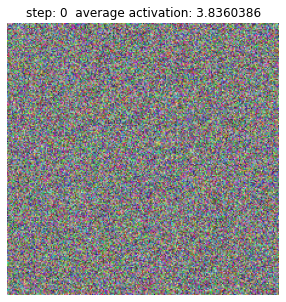

18.23369
tf.Tensor(14.070983, shape=(), dtype=float32)


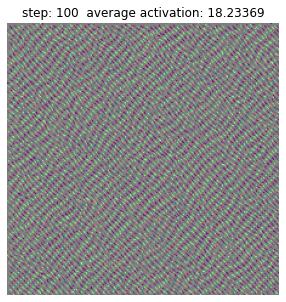

18.64982
tf.Tensor(15.586323, shape=(), dtype=float32)


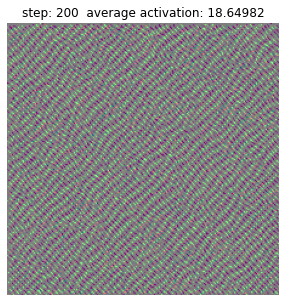

18.791677
tf.Tensor(16.659376, shape=(), dtype=float32)


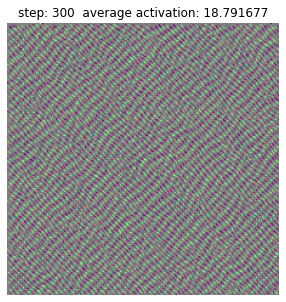

18.81326
tf.Tensor(17.446497, shape=(), dtype=float32)


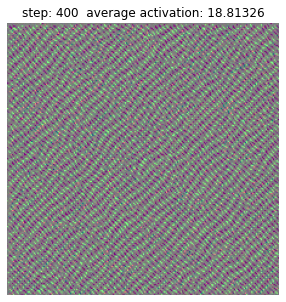

18.802195
tf.Tensor(18.110062, shape=(), dtype=float32)


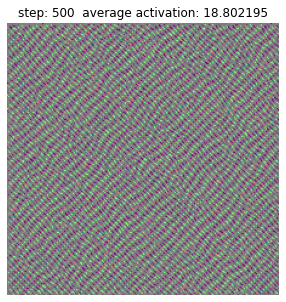

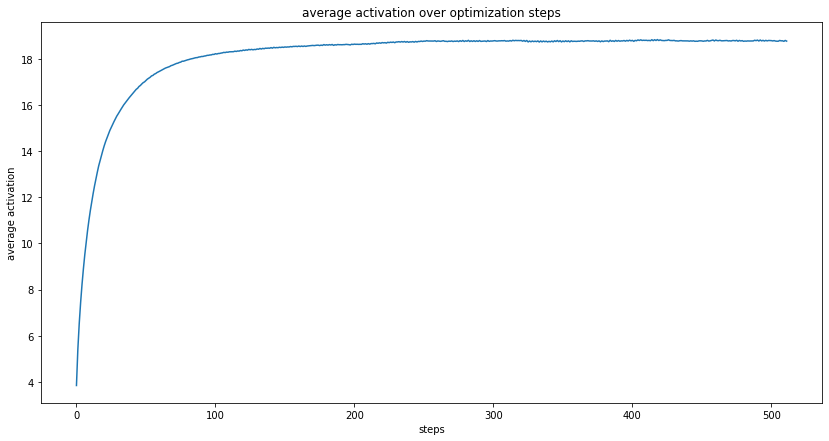

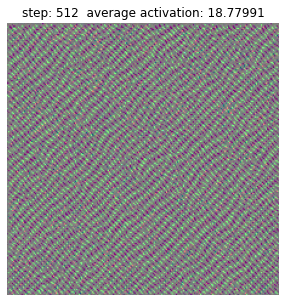

In [ ]:
 

 
layer = 'block_1_project_BN'


unit = 2

model = eval(model_func)
''
feature_map = model.get_layer(layer).output[:,:,:,unit] 


visualization_model = tf.keras.Model(
                            inputs=model.inputs, 
                            outputs=feature_map
                        )
pivot1 = optimize_image(visualization_model, layer, unit=unit, shape=(1,224,224,3), lr=0.05, steps=512, fft=False, decorrelate_colors=False, transformation=False, use_optimizer=True, transformation_steps=1)

 
pivot2 = optimize_image(visualization_model, layer, unit=unit, transformation = False, shape=(1,224,224,3), lr=0.05, steps=512, l1 = 0.001, plot=True)

pivot3 = optimize_image(visualization_model, layer, unit=unit, shape=(1,224,224,3), lr=0.05, steps=512, transformation=False, use_optimizer=True, plot=True)

pivot4 = optimize_image(visualization_model, layer, unit=unit, shape=(1,224,224,3), lr=0.05, steps=512,transformation=False, total_variation=0.0003, decorrelate_colors=False, use_optimizer=True, plot=True)

 
 

### Visualizing classes

In [ ]:
# print classes
preds = np.zeros((1000,1000))

for i in range(1000):
    preds[i,i] = 1
class_names = tf.keras.applications.mobilenet_v2.decode_predictions(preds, top=1)
 
class_dict = {i : name[0][1] for i, name in enumerate(class_names)}
for i in class_dict:
    print(i, ": ", class_dict[i])

40960/35363 [==================================] - 0s 0us/step
0 :  tench
1 :  goldfish
2 :  great_white_shark
3 :  tiger_shark
4 :  hammerhead
5 :  electric_ray
6 :  stingray
7 :  cock
8 :  hen
9 :  ostrich
10 :  brambling
11 :  goldfinch
12 :  house_finch
13 :  junco
14 :  indigo_bunting
15 :  robin
16 :  bulbul
17 :  jay
18 :  magpie
19 :  chickadee
20 :  water_ouzel
21 :  kite
22 :  bald_eagle
23 :  vulture
24 :  great_grey_owl
25 :  European_fire_salamander
26 :  common_newt
27 :  eft
28 :  spotted_salamander
29 :  axolotl
30 :  bullfrog
31 :  tree_frog
32 :  tailed_frog
33 :  loggerhead
34 :  leatherback_turtle
35 :  mud_turtle
36 :  terrapin
37 :  box_turtle
38 :  banded_gecko
39 :  common_iguana
40 :  American_chameleon
41 :  whiptail
42 :  agama
43 :  frilled_lizard
44 :  alligator_lizard
45 :  Gila_monster
46 :  green_lizard
47 :  African_chameleon
48 :  Komodo_dragon
49 :  African_crocodile
50 :  American_alligator
51 :  triceratops
52 :  thunder_snake
53 :  ringneck_snake
5

In [ ]:

layer = 'predictions'

# choose unit of 0 to 999
unit = 32

# load without classifier to access class logits
model = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet', classifier_activation=None)

feature_map = model.get_layer(layer).output[:,unit] 


visualization_model = tf.keras.Model(
                            inputs=model.inputs, 
                            outputs=feature_map
                        )

tf.Tensor([-1.6572464], shape=(1,), dtype=float32)
-1.6572464
tf.Tensor([43.07941], shape=(1,), dtype=float32)


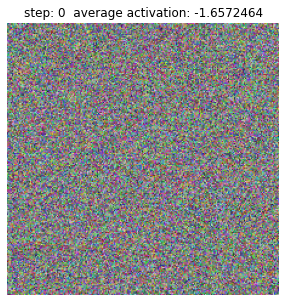

tf.Tensor([-0.97150767], shape=(1,), dtype=float32)
tf.Tensor([0.30780894], shape=(1,), dtype=float32)
tf.Tensor([3.187868], shape=(1,), dtype=float32)
tf.Tensor([4.281769], shape=(1,), dtype=float32)
tf.Tensor([5.451998], shape=(1,), dtype=float32)
tf.Tensor([4.1104813], shape=(1,), dtype=float32)
tf.Tensor([6.7333093], shape=(1,), dtype=float32)
tf.Tensor([6.1628394], shape=(1,), dtype=float32)
tf.Tensor([9.272128], shape=(1,), dtype=float32)
tf.Tensor([10.636156], shape=(1,), dtype=float32)
tf.Tensor([14.748764], shape=(1,), dtype=float32)
tf.Tensor([12.910396], shape=(1,), dtype=float32)
tf.Tensor([17.045372], shape=(1,), dtype=float32)
tf.Tensor([15.605319], shape=(1,), dtype=float32)
tf.Tensor([15.273011], shape=(1,), dtype=float32)
tf.Tensor([14.774171], shape=(1,), dtype=float32)
tf.Tensor([11.59205], shape=(1,), dtype=float32)
tf.Tensor([18.524004], shape=(1,), dtype=float32)
tf.Tensor([10.2604], shape=(1,), dtype=float32)
tf.Tensor([16.843569], shape=(1,), dtype=float32)
tf.T

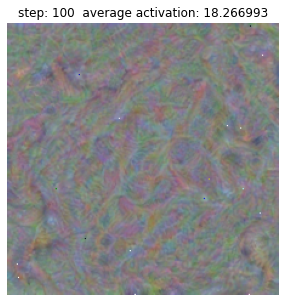

tf.Tensor([26.318632], shape=(1,), dtype=float32)
tf.Tensor([17.542229], shape=(1,), dtype=float32)
tf.Tensor([24.146894], shape=(1,), dtype=float32)
tf.Tensor([20.249495], shape=(1,), dtype=float32)
tf.Tensor([28.04145], shape=(1,), dtype=float32)
tf.Tensor([18.564947], shape=(1,), dtype=float32)
tf.Tensor([22.02389], shape=(1,), dtype=float32)
tf.Tensor([22.41637], shape=(1,), dtype=float32)
tf.Tensor([31.322523], shape=(1,), dtype=float32)
tf.Tensor([10.462482], shape=(1,), dtype=float32)
tf.Tensor([23.775404], shape=(1,), dtype=float32)
tf.Tensor([18.239431], shape=(1,), dtype=float32)
tf.Tensor([29.440228], shape=(1,), dtype=float32)
tf.Tensor([10.625718], shape=(1,), dtype=float32)
tf.Tensor([26.414165], shape=(1,), dtype=float32)
tf.Tensor([23.319227], shape=(1,), dtype=float32)
tf.Tensor([22.0993], shape=(1,), dtype=float32)
tf.Tensor([12.861176], shape=(1,), dtype=float32)
tf.Tensor([23.987926], shape=(1,), dtype=float32)
tf.Tensor([22.05703], shape=(1,), dtype=float32)
tf.Ten

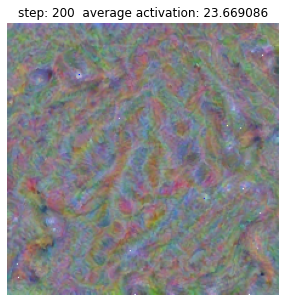

tf.Tensor([30.528332], shape=(1,), dtype=float32)
tf.Tensor([21.337994], shape=(1,), dtype=float32)
tf.Tensor([34.178608], shape=(1,), dtype=float32)
tf.Tensor([17.660711], shape=(1,), dtype=float32)
tf.Tensor([27.672054], shape=(1,), dtype=float32)
tf.Tensor([23.829285], shape=(1,), dtype=float32)
tf.Tensor([27.426582], shape=(1,), dtype=float32)
tf.Tensor([26.850405], shape=(1,), dtype=float32)
tf.Tensor([29.593327], shape=(1,), dtype=float32)
tf.Tensor([22.690403], shape=(1,), dtype=float32)
tf.Tensor([26.33941], shape=(1,), dtype=float32)
tf.Tensor([24.164042], shape=(1,), dtype=float32)
tf.Tensor([31.806787], shape=(1,), dtype=float32)
tf.Tensor([31.271385], shape=(1,), dtype=float32)
tf.Tensor([23.495592], shape=(1,), dtype=float32)
tf.Tensor([27.455402], shape=(1,), dtype=float32)
tf.Tensor([29.457453], shape=(1,), dtype=float32)
tf.Tensor([25.832232], shape=(1,), dtype=float32)
tf.Tensor([24.409733], shape=(1,), dtype=float32)
tf.Tensor([28.69962], shape=(1,), dtype=float32)
tf

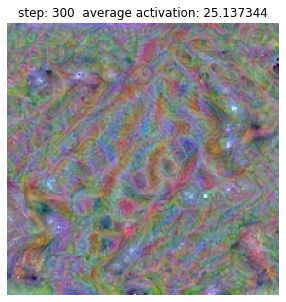

tf.Tensor([32.50229], shape=(1,), dtype=float32)
tf.Tensor([27.606827], shape=(1,), dtype=float32)
tf.Tensor([37.435123], shape=(1,), dtype=float32)
tf.Tensor([21.558727], shape=(1,), dtype=float32)
tf.Tensor([32.373978], shape=(1,), dtype=float32)
tf.Tensor([19.976585], shape=(1,), dtype=float32)
tf.Tensor([34.031784], shape=(1,), dtype=float32)
tf.Tensor([20.633038], shape=(1,), dtype=float32)
tf.Tensor([30.119585], shape=(1,), dtype=float32)
tf.Tensor([19.868752], shape=(1,), dtype=float32)
tf.Tensor([31.378044], shape=(1,), dtype=float32)
tf.Tensor([25.604721], shape=(1,), dtype=float32)
tf.Tensor([33.640095], shape=(1,), dtype=float32)
tf.Tensor([23.777092], shape=(1,), dtype=float32)
tf.Tensor([37.004414], shape=(1,), dtype=float32)
tf.Tensor([22.597158], shape=(1,), dtype=float32)
tf.Tensor([37.42405], shape=(1,), dtype=float32)
tf.Tensor([25.757986], shape=(1,), dtype=float32)
tf.Tensor([30.641838], shape=(1,), dtype=float32)
tf.Tensor([31.265936], shape=(1,), dtype=float32)
tf

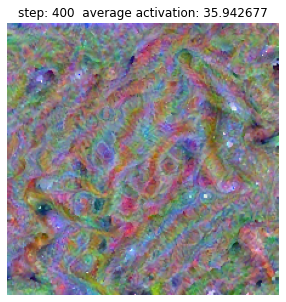

tf.Tensor([32.543953], shape=(1,), dtype=float32)
tf.Tensor([30.803684], shape=(1,), dtype=float32)
tf.Tensor([33.565697], shape=(1,), dtype=float32)
tf.Tensor([34.240692], shape=(1,), dtype=float32)
tf.Tensor([36.470905], shape=(1,), dtype=float32)
tf.Tensor([22.969408], shape=(1,), dtype=float32)
tf.Tensor([37.29995], shape=(1,), dtype=float32)
tf.Tensor([28.645054], shape=(1,), dtype=float32)
tf.Tensor([39.688602], shape=(1,), dtype=float32)
tf.Tensor([31.697304], shape=(1,), dtype=float32)
tf.Tensor([36.851105], shape=(1,), dtype=float32)
tf.Tensor([32.9523], shape=(1,), dtype=float32)
tf.Tensor([35.15936], shape=(1,), dtype=float32)
tf.Tensor([30.683712], shape=(1,), dtype=float32)
tf.Tensor([34.508617], shape=(1,), dtype=float32)
tf.Tensor([31.741907], shape=(1,), dtype=float32)
tf.Tensor([34.749397], shape=(1,), dtype=float32)
tf.Tensor([26.057098], shape=(1,), dtype=float32)
tf.Tensor([37.354866], shape=(1,), dtype=float32)
tf.Tensor([28.477327], shape=(1,), dtype=float32)
tf.T

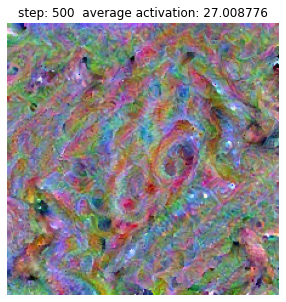

tf.Tensor([42.731083], shape=(1,), dtype=float32)
tf.Tensor([32.42364], shape=(1,), dtype=float32)
tf.Tensor([36.53457], shape=(1,), dtype=float32)
tf.Tensor([34.769726], shape=(1,), dtype=float32)
tf.Tensor([37.22063], shape=(1,), dtype=float32)
tf.Tensor([36.331734], shape=(1,), dtype=float32)
tf.Tensor([40.253353], shape=(1,), dtype=float32)
tf.Tensor([31.876543], shape=(1,), dtype=float32)
tf.Tensor([42.900436], shape=(1,), dtype=float32)
tf.Tensor([34.22687], shape=(1,), dtype=float32)
tf.Tensor([40.408405], shape=(1,), dtype=float32)
tf.Tensor([30.506199], shape=(1,), dtype=float32)
tf.Tensor([30.986258], shape=(1,), dtype=float32)
tf.Tensor([30.680832], shape=(1,), dtype=float32)
tf.Tensor([33.484646], shape=(1,), dtype=float32)
tf.Tensor([30.234612], shape=(1,), dtype=float32)
tf.Tensor([38.68583], shape=(1,), dtype=float32)
tf.Tensor([30.4758], shape=(1,), dtype=float32)
tf.Tensor([41.492687], shape=(1,), dtype=float32)
tf.Tensor([26.932337], shape=(1,), dtype=float32)
tf.Tens

KeyboardInterrupt: ignored

In [ ]:
pivot2 = optimize_image(visualization_model, feature_map, unit=unit, shape=(1,224,224,3), lr=0.05, steps=1024, total_variation=0.0003, transformation=False, blur='bilateral', blur_step = 2, plot=True)


### Visualize Each Channel of a Layer
The path for saving needs to adapted to your drive file structures

In [ ]:
units = range(24)
layer = 'predictions'

for unit in units:
  
    model = eval(model_func)

    feature_map = model.get_layer(layer).output[:,:,:,unit] 


    visualization_model = tf.keras.Model(
                                inputs=model.inputs, 
                                outputs=feature_map
                            )
    img = optimize_image(visualization_model, feature_map, unit=unit, shape=(1,224,224,3), lr=0.05, steps=512, decorrelate_colors=False, transformation=False, total_variation= 0.0003, use_optimizer=True, transformation_steps=1, plot=True)
    path = "/content/drive/My Drive/Colab Notebooks/Bachelor Arbeit/images/"+ layer + "/" + str(unit) + "_my_implementation" + ".png"
    tf.keras.preprocessing.image.save_img(str(path), img)



ValueError: ignored

### Visualize for different learning rates
Comparison for different learning rates or different hyperparameters.





In [ ]:
# visualize for differebt learning rates
learning_rates = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
for lr in learning_rates:
    img = optimize_image(model, feature_map_2, unit=unit, shape=(1,224,224,3), lr=lr, steps=512, fft=False, decorrelate_colors=False, transformation=True, use_optimizer=True)





## NEB Algorithm

In [ ]:
def initialize_path(img1, img2, n_pivots):
    ''' Performs linear interpolation between img1 and img2 
    returns: n_pivots intermediate images '''
    interpolation_factors = np.linspace(0,1,n_pivots)
    #print(interpolation_factors)
    
    path = []
    for i in interpolation_factors:
        intermediate = np.zeros(img1.shape)
        intermediate = img1 * (1-i) + img2* i
        path.append(intermediate)
    #path.append(img2)
    return tf.convert_to_tensor(path, dtype=np.float32)
img1 = np.reshape(np.arange(0,224*224*3),(224,224,3))
img2 = np.reshape(np.arange(224*224*3,0,-1),(224,224,3))


def euclidian_distance(i1, i2):
    return np.sqrt(np.sum((i1-i2)**2))


def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)



### Plot Initial Linear Path

In [ ]:
n = 20
imgs = initialize_path(pivot1, pivot2, n)
print(euclidian_distance(imgs[0], imgs[1]))
fig = plt.figure(figsize=(20,20))
for i, img in enumerate(imgs):
    plt.subplot(int(np.sqrt(n))+1,int(np.sqrt(n))+1,i+1)
    plt.axis('off')
    img_show = tf.cast(255*(img + 1.0)/2.0, tf.uint8)
    plt.imshow(img_show)
plt.show()

In [ ]:
def check_interpolations(visualization_model, imgs, interpolation_steps, plot=False):
    '''
    Gets a list of images and interpolates linearly between them and computes the activations of the interpolations
    Checks if the interpolations have a lower activation
    '''
    interpolations = []
    interpolation_factors = np.linspace(0, 1, interpolation_steps, endpoint=False)
    
    for i in range(len(imgs)-1):
        img_1 = imgs[i]
        img_2 = imgs[i+1]
        
        for i in interpolation_factors:
            intermediate = np.zeros(img_1.shape)
            intermediate = img_1 * (1-i) + img_2* i
            interpolations.append(intermediate)
    interpolations.append(imgs[-1])
    batch = tf.convert_to_tensor(interpolations)
    out_fm = visualization_model(batch)
    # class visualizations already reduced shape
    if len(tf.shape(out_fm)) > 1:
        average_activations = tf.reduce_mean(out_fm, axis=[1,2])
    else:
        average_activations = out_fm
     
    reference_1 = 0
    reference_2 = interpolation_steps
    dense_enough = True
    for j in range(1,tf.shape(average_activations)[0]):
        if j == reference_2:
            reference_1 = reference_2
            reference_2 = j + interpolation_steps
    
        elif (average_activations[reference_1] > average_activations[j]) and (average_activations[reference_2] > average_activations[j]):
            dense_enough = False
        
    if plot:   
        categories = np.zeros(tf.shape(average_activations), dtype='bool')
        index = [i for i in range(0, average_activations.shape[0], interpolation_steps)]

        categories[index] = True
        
        n_pivots = np.asarray(range(tf.shape(average_activations)[0]))
        #colormap = np.array(['blue', 'yellow'])
        activations_ar = np.asarray(average_activations)

        fig = plt.figure(figsize=(18,5))
        ax = fig.add_subplot(111)
        ax.set_title("Interpolation Activations")
        ax.set_xlabel("pivots")
        ax.set_ylabel(" average activations")
        
        ax.scatter(n_pivots[categories], activations_ar[categories], label='original pivots')
        ax.scatter(n_pivots[~categories], activations_ar[~categories], label='interpolations')

        legend1 = ax.legend(loc="best")
        ax.add_artist(legend1)

        plt.show()


    

    return dense_enough, np.asarray(average_activations), interpolations

In [ ]:
# check the average activations of linear interpolation between the two starting images
imgs = initialize_path(pivot3, pivot4, 20)
batch = tf.convert_to_tensor(imgs)
activations = visualization_model(batch)
average_activations = tf.reduce_mean(activations, axis=[1,2])
plt.title("Linear interpolation activations")
plt.plot(range(tf.shape(average_activations)[0]), average_activations, 'o-')
plt.show()

NameError: ignored

### NEB Implementation

In [ ]:
def redistribute_pivots(pivots):

    # The curent distances between elements on chain
    current_distances = [euclidian_distance(pivots[i], pivots[i+1])for i in range(len(pivots)-1)]
    avg_distance = np.sum(current_distances)/(len(current_distances))
    # target positions are equally spaced by distance
    target_positions = np.cumsum(np.ones(len(current_distances)) * avg_distance)
    # First pivot remains unchanged
    new_pivots = [pivots[0]]
    # Put each new item measured along line on the line
    last_idx = 0  # Index of previous pivot
    pos_prev = 0.  # Position of previous pivot on chain
    pos_next = current_distances[last_idx]  # Position of next pivot on chain
    for i in range(1, len(current_distances)):
        position = target_positions[i - 1]
        while position > pos_next:
            last_idx += 1
            pos_prev = pos_next
            pos_next += current_distances[last_idx]

        t = (position - pos_prev) / (pos_next - pos_prev)
        new_pivots.append(t * pivots[last_idx + 1] + (1 - t) * pivots[last_idx])
    new_pivots.append(pivots[-1])

    return tf.convert_to_tensor(new_pivots)

def NEB(visualization_model, pivots, max_steps=1000, lr=0.01, total_variation=0.001, blur_gradient = False, freeze_pivots=False, plot=False):

    # reload model util Unknwon Graph error is fixed
     
    
    # generate intial path with n+2 pivots
    #pivots = initialize_path(img1, img2, n_pivots+2)
    steps_ar = []
    average_activations = []
    #pivot_storage = []
    #pivot_storage.append(pivots)

    # get starting activations
    out_fm = visualization_model(pivots)

    
    # only reduce for feature maps, class values will throw error
    if len(tf.shape(out_fm)) > 1:
        activations = tf.reduce_mean(out_fm, axis=[1,2])
    else:
        activations = out_fm
     

    min_activation = tf.reduce_min(activations)
    
    max_activation = tf.reduce_max(activations)

    # get the minimum activation of img and img 2
    
    min_constant = tf.minimum(activations[0], activations[-1])
    max_constant = tf.maximum(activations[0], activations[-1])


    # threhold for stopping
    threshold = min_constant # - (min_constant/min_activation)
    training_threshold = max_constant

    trainable_pivots = np.ones(len(pivots),dtype='bool')
    trainable_pivots[[0,-1]] = False

    record_pivot = [pivots[int(len(pivots)/2)]]
    

 
    # run the optimization until either the maximum number of steps is reached or until each activations surpasses threshold
    step = 0
    while (not np.all(np.asarray(activations)[1:-1] > threshold) and step < max_steps) or step == 0:
        
        


        ### alternative gradient computation
        with tf.GradientTape() as tape:
            tape.watch(pivots)
            # feed images to network
            out_fm = visualization_model(pivots)

            if len(tf.shape(out_fm)) > 1:
                activations = tf.reduce_mean(out_fm, axis=[1,2])
            else:
                activations = out_fm

            if total_variation != None:
                regularization_penalty = tf.image.total_variation(pivots) * total_variation
            else:
                regularization_penalty = tf.zeros(tf.shape(pivots)[0])
            # compute gradients
            
            
            objective = activations - regularization_penalty
            gradients = tape.gradient(objective, pivots)
            # normalize gradients
            gradients /= tf.math.reduce_std(gradients) + 1e-8
            # no gradients for start and end image
            gradients = tf.convert_to_tensor(gradients[1:len(pivots)-1])

            if blur_gradient:
                b_gradients = []
                for g in gradients:
                    b_g = cv2.GaussianBlur(np.asarray(tf.squeeze(g)),(7,7), 1.5)
                    b_g = tf.convert_to_tensor(b_g)
                    b_gradients.append(b_g)
                gradients = tf.convert_to_tensor(b_gradients)


        
        
        # freeting pivots
        if freeze_pivots:
            trainable_pivots = np.where(activations <= training_threshold, True, False)
        
        
        # Compute local tangent
        # point in direction of niehgbor with higher activation
        #tangents = [pivots[i+1] - pivots[i] if activations[i+1] > activations[i-1] else pivots[i] - pivots[i-1] for i in range(1,len(pivots)-1)]
        # point in direction of neighbor with lower activations
        tangents = [pivots[i+1] - pivots[i] if objective[i+1] < objective[i-1] else pivots[i] - pivots[i-1] for i in range(1,len(pivots)-1)]

        tangents = tangents / (tf.norm(tangents) + 1e-30)


        # Compute loss forces
        loss_force = gradients -(gradients * tangents) * tangents

        #loss_force = tf.concat(tf.zeros(img1.shape, dtype = np.float32), loss_force, tf.zeros(img1.shape, dtype = np.float32))

        # Apply loss forces

        
        new_pivots = []
        new_pivots.append(pivots[0])
        for i in range(1,len(pivots)-1):
            if trainable_pivots[i]:
                new_pivots.append(pivots[i] + lr * loss_force[i-1])
            else:
                new_pivots.append(pivots[i])
        new_pivots.append(pivots[-1])
        pivots = tf.convert_to_tensor(new_pivots)
 

        
     


        pivots =  redistribute_pivots(pivots)
        #pivot_storage.append(pivots)

        #
        

       
         
        steps_ar.append(step)
        average_activations.append(activations)
        #record_pivot.append(pivots[int(len(pivots)/2)])
        if step % 20 == 0 and plot:
            print("step:", step)
            #print("variation penalty:", regularization_penalty)
            # plot activations
            plt.figure(figsize=(18,5))
            plt.title("pivot activations after step " + str(step))
            plt.xlabel("pivots")
            plt.ylabel("average activations")
            plt.ylim(min_activation-1, max_activation + 15)     
            plt.plot(range(len(activations)), activations, 'o-')
            plt.show()

            #plt.figure(figsize=(18,5))
            #plt.title("pivot objective after step " + str(step))
            #plt.xlabel("pivots")
            #plt.ylabel("objective")
            #plt.ylim(min_activation-1, max_activation + 15)     
            #plt.plot(range(len(objective)), objective, 'o-')
            #plt.show()


            # plot images
            #plt.figure(figsize=(30,40))
            #for i,pivot in enumerate(pivots):
             #   plt.subplot(1,len(pivots),i+1)
             #   plt.axis('off')
             #   img_show = tf.cast(255*(pivot + 1.0)/2.0, tf.uint8)
             #   plt.imshow(img_show)
            #plt.plot(activations)
            #plt.show()
        step += 1
    if plot:
        print("step:", step)
        #print("variation penalty:", regularization_penalty)
        # plot activations
        plt.figure(figsize=(18,5))
        plt.title("final pivot activations after step " + str(step))
        plt.xlabel("pivots")
        plt.ylabel("average activations")
        plt.ylim(min_activation-1, max_activation + 15)     
        plt.plot(range(len(activations)), activations, 'o-')
        plt.show()
      
    

    return list(pivots), steps_ar, np.asarray(average_activations), record_pivot#, pivot_storage


### NEB Wrapper
Computes NEB paths between the starting images. After NEB is run, linear interpolation between pivots are created to increase the framerate. If they have lower activations than the neighboring pivots, NEB is run again with interpolations as additional pivots.

In [ ]:
def NEB_Wrapper(visualization_model, starting_images, n_pivots=20, max_steps=500, lr=0.005, total_variation=0.0015, n_interpolations = 3, blur_gradient = True, plot=False):
    ''' receives a list of optimized images and rund the NEB algorithm between neighboring images

    returns:
        images: list of optimized images
        activations: activations of images over the steps
        steps: list of steps
    '''
    final_images = []
    final_activations = []
    # keep track which images were starting images for plotting 
    start_positions = []
    for i in range(len(starting_images)-1):
        # go through images and perform NEB between them
        img1 = starting_images[i]
        img2 = starting_images[i+1]
        # linear interpolation as initial path
        pivots = initialize_path(img1, img2, n_pivots+2)
        images, steps, average_activation, _ = NEB(visualization_model, pivots, max_steps=max_steps, lr=lr, total_variation=total_variation, plot=plot)
        # check if interpolations have lower activations
        dense_enough, activations_i, interpolations = check_interpolations(visualization_model, images, interpolation_steps=n_interpolations +1, plot=plot)
        if dense_enough:
            images = interpolations
            activations = activations_i
        else:
            # if interpolations have lower activations run NEB again with interpolations as extra pivots
            print("Interpolation activations to low, running NEB again with interpolations as pivots")
            images, steps, average_activation_2, _ = NEB(visualization_model, tf.convert_to_tensor(interpolations), max_steps=100, lr=lr, total_variation=total_variation, plot=plot)
            dense_enough, activations_i, interpolations = check_interpolations(visualization_model, images, interpolation_steps=1, plot=plot)
            # append activations for plotting

            #average_activation = np.append(average_activation, average_activation_2[:,range(0, average_activation_2.shape[1],3)], axis=0)
            
            if dense_enough:
                images = interpolations
                activations = activations_i
            else:
                print("still not dense enough")

        # append results, expect the last image as it is the first of the next sequence
        start_positions.append(len(final_activations))
        final_images.extend(images[:-1])
        final_activations.extend(activations[:-1])
        print("steps", steps[-1])

         

    # append last image for the last sequence
    final_images += [images[-1]]
    final_activations += [activations[-1]]
    start_positions.append(len(final_activations)-1)

    if plot:
         

        print(start_positions)
        activations_ar = np.asarray(final_activations)
        categories = np.zeros(activations_ar.shape[0], dtype='bool')
        #index = [i for i in range(0, average_activations.shape[0], interpolation_steps)]

        categories[start_positions] = True
        n_pivots = np.arange(activations_ar.shape[0])
        

        fig = plt.figure(figsize=(18,5))
        ax = fig.add_subplot(111)
        ax.set_title("Final Activations")
        ax.set_xlabel("pivots")
        ax.set_ylabel(" average activations")
        
        ax.scatter(n_pivots[categories], activations_ar[categories], label='starting images', s=40)
        ax.scatter(n_pivots[~categories], activations_ar[~categories], label='intermediate images')

        legend1 = ax.legend(loc="best")
        ax.add_artist(legend1)

        plt.show()
         

    return final_images, final_activations, start_positions





### Some Magic to Load Images

In [ ]:
! ls "/content/drive/My Drive/Colab Notebooks/Bachelor Arbeit/images/"
folders = glob.glob("/content/drive/My Drive/Colab Notebooks/Bachelor Arbeit/images/*")
sample_dict = { i : x for i, x in enumerate(folders)}
print("Available Layers:")
for i in sample_dict:
  print(i, f": {os.path.basename(sample_dict[i])}")

block_10_project_BN  block_2_add	 block_5_add		 block_9_add
block_12_add	     block_3_project_BN  block_7_depthwise_relu
block_14_add	     block_4_add	 block_8_add
Available Layers:
0 : block_8_add
1 : block_9_add
2 : block_10_project_BN
3 : block_12_add
4 : block_14_add
5 : block_5_add
6 : block_4_add
7 : block_2_add
8 : block_3_project_BN
9 : block_7_depthwise_relu


In [ ]:
#@title Choose which folder to use { form-width: "400px" }
FILE =  3#@param {type:"integer"}

foldername = sample_dict[FILE]

In [ ]:
# load picture corresponding to unit

#folder_path = "/content/drive/My Drive/Colab Notebooks/Bachelor Arbeit/images/" + foldername
path1 = foldername + "/" + str(unit) + "_lucid" + ".png"
#path2 = folder_path + feature_map_lucid + str(unit) + "nofft" + ".png"
print(path1)
pivot_lucid = np.asarray(tf.keras.preprocessing.image.load_img(path1), dtype=np.float32)
#pivot2 = np.asarray(tf.keras.preprocessing.image.load_img(path2), dtype=np.float32)
 
pivot_lucid = normalize_image(pivot_lucid)
#pivot2 = normalize_image(pivot2)

 

NameError: ignored

#### Test NEB Algorithm

In [ ]:
# NEB for different TV penalties

starting_images = initialize_path(pivot3, pivot4, 30)
images, steps, average_activation, _ = NEB(visualization_model=visualization_model, pivots= starting_images, lr=0.002, blur_gradient = False, freeze_pivots=True, total_variation = 0, plot=True)
images_tv_1, steps_tv_1, average_activation_tv_1, _ = NEB(visualization_model=visualization_model, pivots= starting_images, lr=0.002, blur_gradient = False,freeze_pivots=True, total_variation = 0.0005, plot=True)
images_tv_2, steps_tv_2, average_activation_tv_2, _ = NEB(visualization_model=visualization_model, pivots= starting_images, lr=0.002, blur_gradient = False, freeze_pivots=True,total_variation = 0.001, plot=True)
images_tv_3, steps_tv_3, average_activation_tv_3, _ = NEB(visualization_model=visualization_model, pivots= starting_images, lr=0.002, blur_gradient = False,freeze_pivots=True, total_variation = 0.0015, plot=True)




NameError: ignored

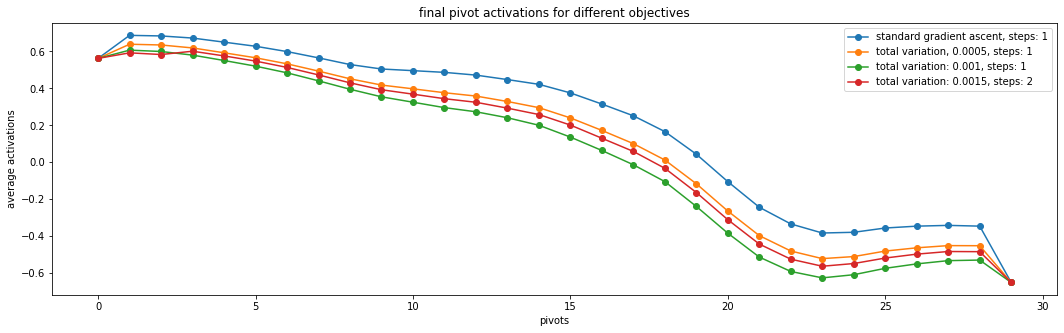

In [ ]:
# plot different final activation
final_activations = average_activation[-1,:]
final_activations_tv_1 = average_activation_tv_1[-1,:]
final_activations_tv_2 = average_activation_tv_2[-1,:]
final_activations_tv_3 = average_activation_tv_3[-1,:]



#print("variation penalty:", regularization_penalty)
# plot activations
plt.figure(figsize=(18,5))
plt.title("final pivot activations for different objectives")
plt.xlabel("pivots")
plt.ylabel("average activations")
#plt.ylim(min_activation-1, max_activation + 15)     
plt.plot(range(len(final_activations)), final_activations, 'o-', label='standard gradient ascent, steps: ' + str(steps[-1]) )
plt.plot(range(len(final_activations_tv_1)), final_activations_tv_1, 'o-', label='total variation, 0.0005, steps: '+ str(steps_tv_1[-1]))
plt.plot(range(len(final_activations_tv_2)), final_activations_tv_2, 'o-', label='total variation: 0.001, steps: '+ str(steps_tv_2[-1]))
plt.plot(range(len(final_activations_tv_3)), final_activations_tv_3, 'o-', label='total variation: 0.0015, steps: '+ str(steps_tv_3[-1]))
plt.legend(loc="best")

plt.show()
      



#### Test NEB Wrapper

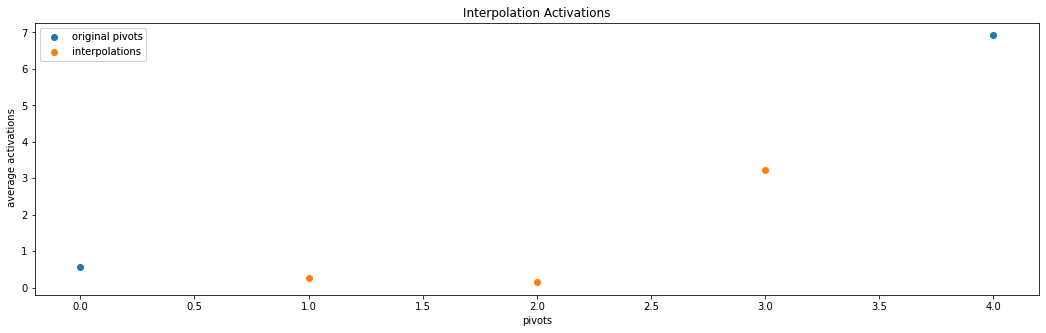

In [ ]:
dense_enough, activations_i, interpolations = check_interpolations(visualization_model, [pivot3, pivot_lucid], interpolation_steps=4, plot=True)


step: 0


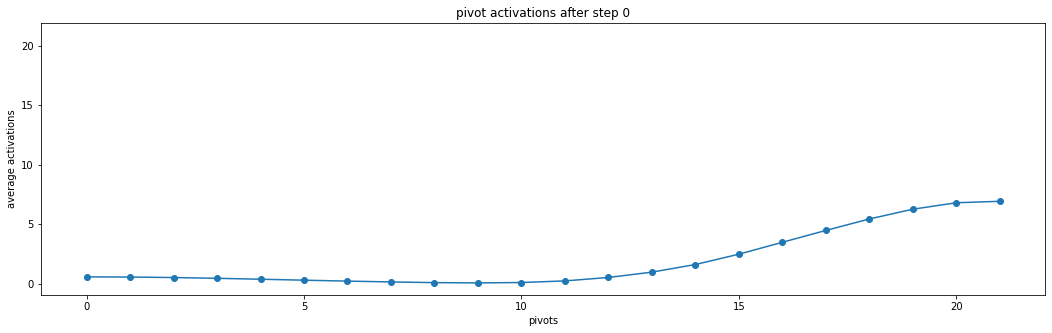

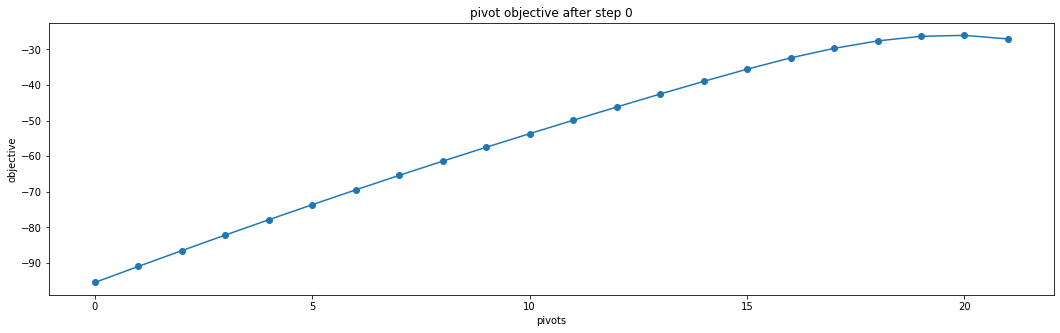

step: 7


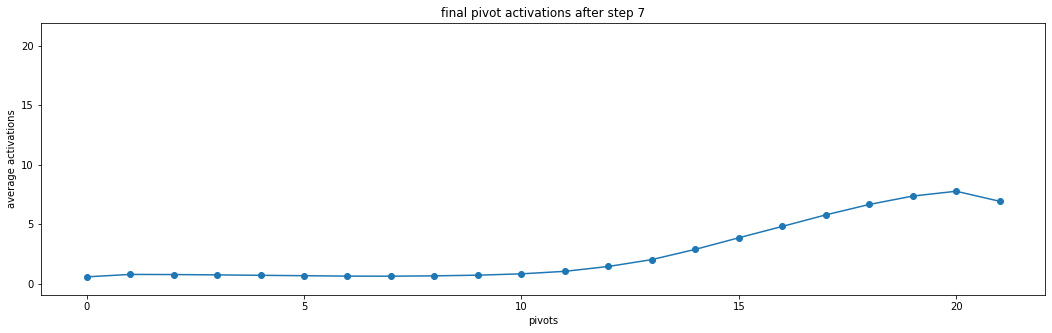

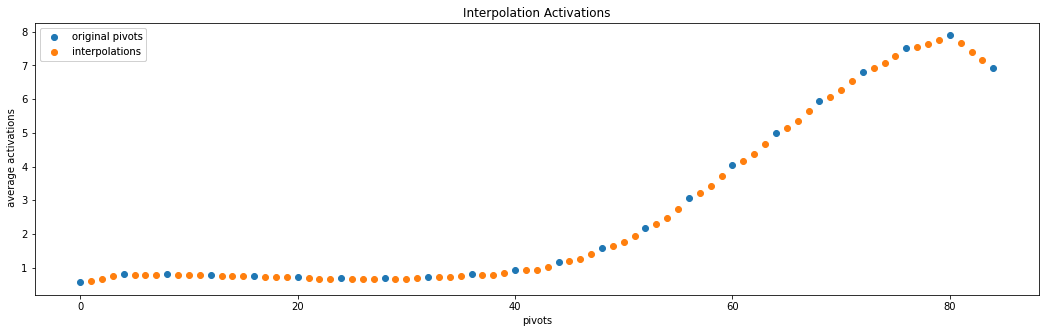

Sampling not dense enough, run NEB again with interpolations as pivots and half the steps
step: 0


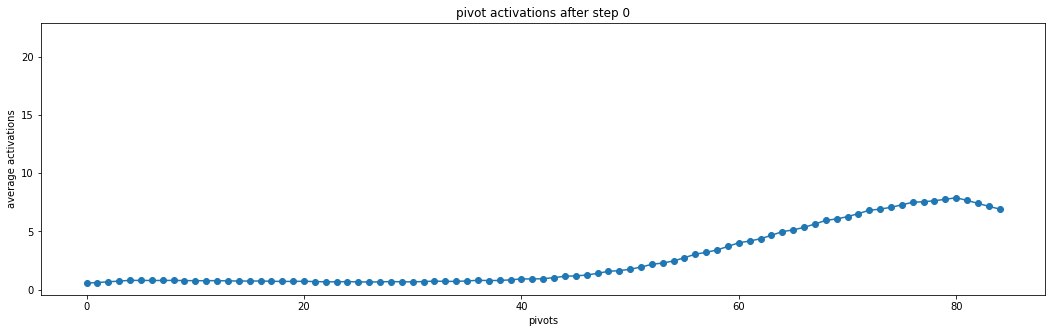

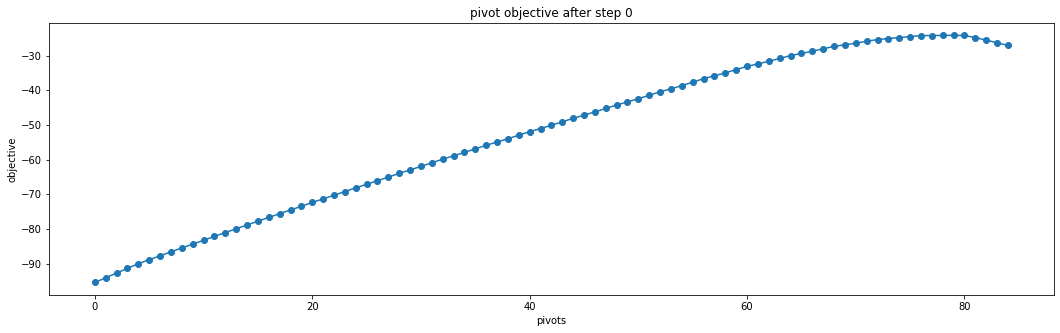

step: 1


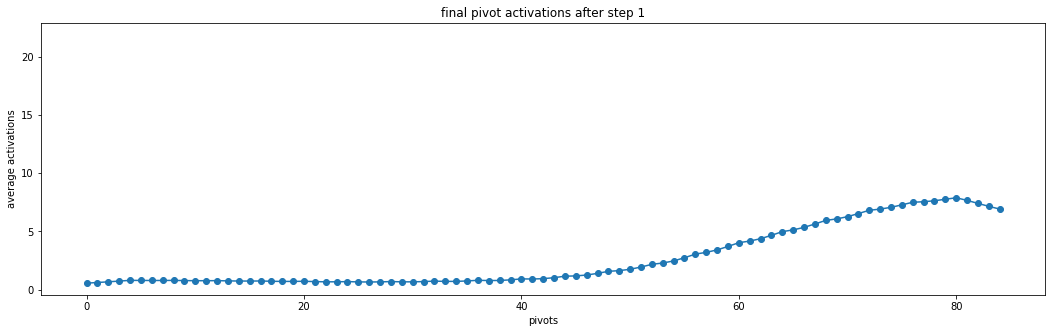

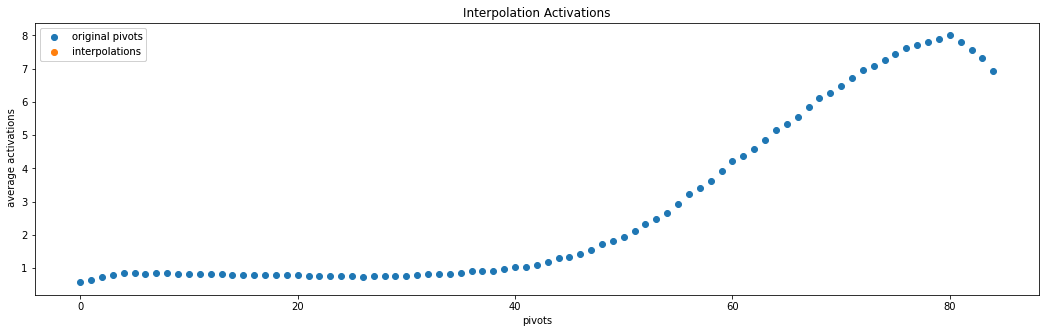

steps 0


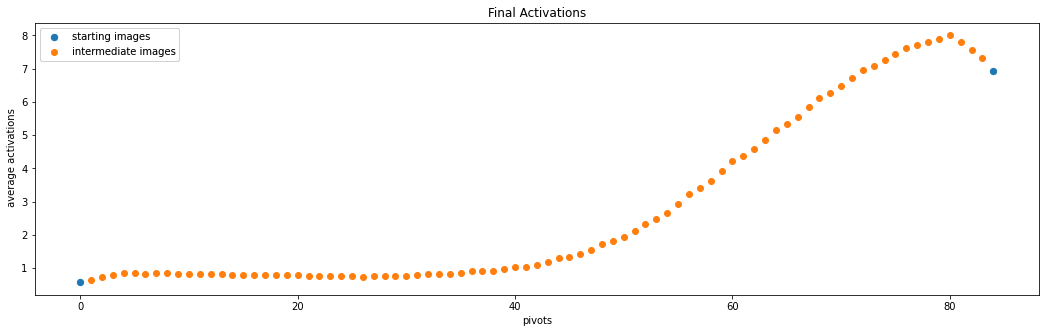

In [ ]:
images, activations, start_positions =  NEB_Wrapper(visualization_model, [pivot3, pivot_lucid], n_pivots=20, max_steps=100, lr=0.001, total_variation=0.0005, plot=True)

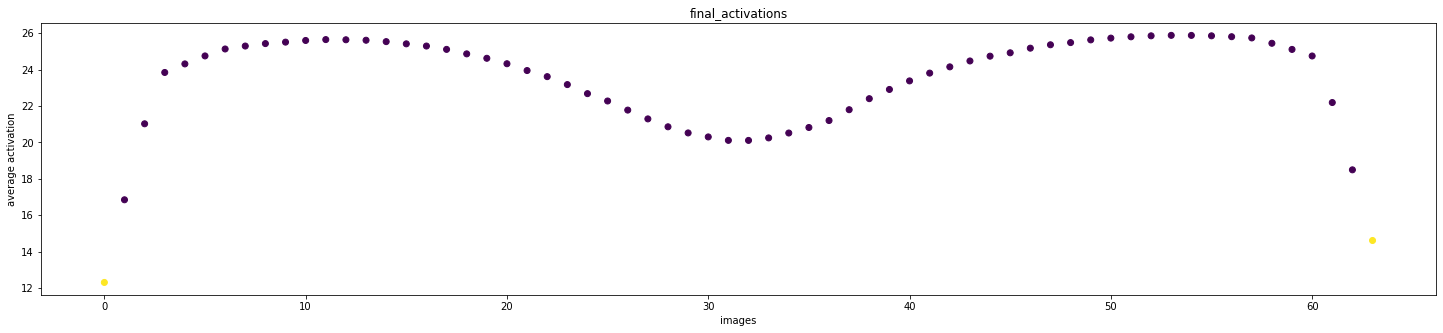

In [ ]:
# plot final activations
categories = np.zeros(len(activations),dtype=int)
categories[start_positions] = 1

activations=np.asarray(activations)
plt.figure(figsize=(25,5))
plt.xlabel("images")
plt.ylabel("average activation")
plt.title("final_activations")
plt.scatter(range(len(activations)), activations, c=categories)

plt.show()

True
activationsshape tf.Tensor([253  14  14], shape=(3,), dtype=int32)
True


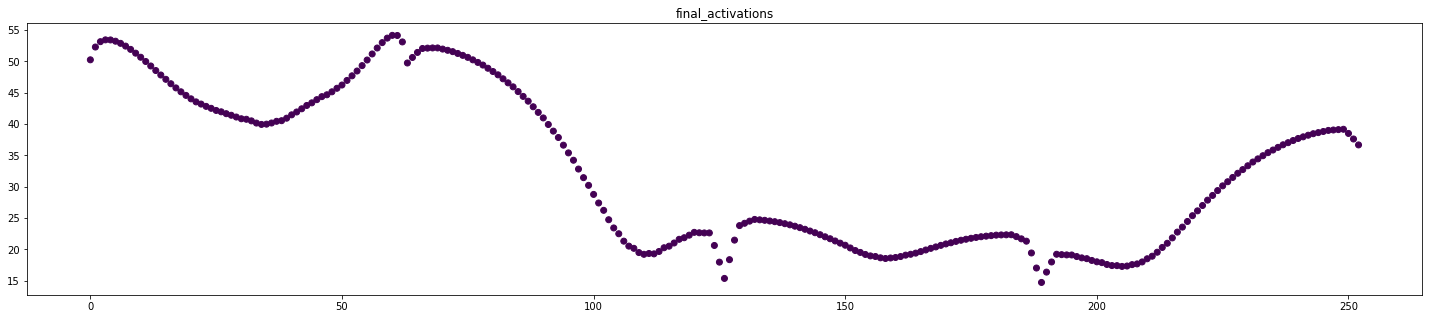

In [ ]:
# test if interpolations between pivots have a smaller activation
# interpolation steps including img1 and excluding img 2 example: 4 -> [0,0.25,0.5,0,75]
interpolation_steps = 1
print(np.all(np.asarray(activations) > 10))
dense, activations, _ = check_interpolations(visualization_model, images, interpolation_steps)
print(dense)
#print(tf.shape(activations))
color_categories = np.zeros(tf.shape(activations))
mask = [i for i in range(0, activations.shape[0], interpolation_steps)]

color_categories[mask] = 1

plt.figure(figsize=(25,5))
plt.title("final_activations")
plt.scatter(range(tf.shape(activations)[0]), activations, c=color_categories)
plt.show()

(45, 30) (45,)


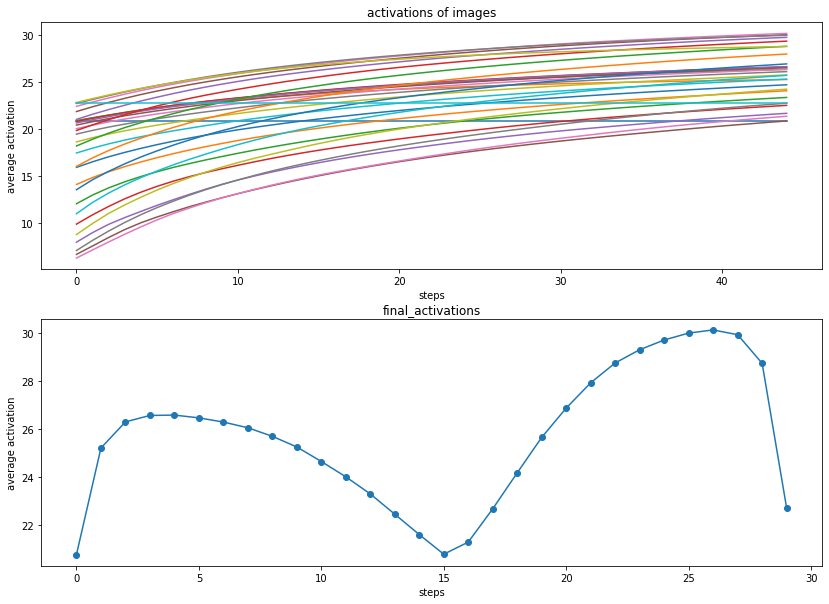

In [ ]:
# plot activations
average_activation = np.asarray(average_activation) 
steps = np.asarray(steps)
 
print(average_activation.shape,steps.shape)
plt.figure(figsize = (14,10))
plt.subplot(2,1,1)
plt.title("activations of images")
plt.xlabel("steps")
plt.ylabel("average activation")
for i in range(average_activation.shape[1]):
    plt.plot(steps, average_activation[:,i])
plt.subplot(2,1,2)
plt.xlabel("steps")
plt.ylabel("average activation")
plt.title("final_activations")
plt.plot(range(average_activation.shape[1]), average_activation[-1], 'o-')
plt.show()

### Create Video

In [ ]:
from matplotlib import animation, rc
from IPython.display import HTML


#filename = str(feature_map) + str(unit) + ".mp4"
#path= r'/content/drive/My Drive/Colab Notebooks/Bachelor Arbeit/Videos/' + filename

def animate_images(images, activations, fps=30, mirror=False, save_path=None):
    images_c = images.copy()
    activations = np.asarray(activations)
    if mirror:
        #images_r = images
        images_c = images_c + images_c[::-1]
        activations = np.append(activations, activations[::-1])
    plt_images = []
    n_images = range(len(images_c))

    fig = plt.figure(figsize=(17,7))
    ax = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    ax.set_axis_off()
    ax2.set_xticks(n_images)
    ax2.set_ylim(np.min(activations)-5,np.max(activations)+5)
    ax2.spines['bottom'].set_position(('data', np.min(activations)-4))
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)


    ax2.xaxis.set_minor_locator(plt.MultipleLocator(5))
    ax2.xaxis.set_ticklabels([])




    
    #fig.tight_layout()
    #plt.axis('off')
    #plt.gca().set_axis_off()
    fig.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    plt.margins(0,0)
    #plt.gca().xaxis.set_major_locator(plt.NullLocator())
    #plt.gca().yaxis.set_major_locator(plt.NullLocator())
    for i,image in enumerate(images_c):
        
        #t = ax.annotate(str(activations[i]), xy=(0.8, 0.95), xytext =(0,0.5)) # add text

        
        #txt = plt.text(0,100,'text')
        t = plt.text(0.5, 0.95, str(activations[i]), horizontalalignment='center', verticalalignment='bottom', transform=ax2.transAxes)
        mark_on = [i]
        plt_ac,  = ax2.plot(n_images,activations, color='blue', marker='o', ms = 15, mfc = 'red', mec ='black', markevery = mark_on)
        #plt_ac,  = ax2.scatter(n_images,activations, marker='o', markevery = mark_on)

        #color_categories = np.zeros(activations.shape)
        #mask = [i]
        #color_categories[mask] = 1
        #plt_ac  = ax2.scatter(n_images,activations, c=color_categories)

        plt_image = ax.imshow(tf.cast(255*(image + 1.0)/2.0, tf.uint8), animated=True)
        #plt_image.text(0,0,'20')
        plt_images.append([plt_image, plt_ac, t])
    ani = animation.ArtistAnimation(fig, plt_images, interval=1000/fps, blit=True, repeat=True, repeat_delay=2000)
    if save_path != None:
        writer = animation.FFMpegWriter(fps=fps)
        ani.save(save_path, writer=writer)
    plt.close()
    rc('animation', html='jshtml')
    return HTML(ani.to_html5_video())




In [ ]:
#imgs = initialize_path(pivot1, pivot2,60)
activations_plot = average_activation_tv_2[-1,:]
fps = 10
video = animate_images(images_tv_2, activations_plot, fps=fps, mirror=False)
video


NameError: ignored

In [ ]:
# pivot analysis
n = activations_plot[1:-1].argmin()
print(n)
n += 1
img1 = images[n]
img2 = images_tv_1[n]
img3 = images_tv_2[n]
img4 = images_tv_3[n]

difference_img = img1-img2
print(euclidian_distance(img1,img2))

fig = plt.figure(figsize=(15,5))
plt.subplots_adjust(wspace=0.05)
plt.subplot(1,4,1)
plt.title('tv = 0')
plt.axis('off')
img_show = tf.cast(255*(img1 + 1.0)/2.0, tf.uint8)
plt.imshow(img_show)
#plt.title("step: " + str(1)+ "  average activation: " + str(average_activations[0].numpy()))
plt.subplot(1,4,2)
plt.title('tv = 0.0005')

plt.axis('off')
img_show = tf.cast(255*(img2 + 1.0)/2.0, tf.uint8)
plt.imshow(img_show)
#plt.title("step: " + str(50)+ "  average activation: " + str(average_activations[49].numpy()))
plt.subplot(1,4,3)
plt.axis('off')
plt.title('tv = 0.001')

img_show = tf.cast(255*(img3 + 1.0)/2.0, tf.uint8)
plt.imshow(img_show)
plt.subplot(1,4,4)
plt.axis('off')
plt.title('tv = 0.0015')

img_show = tf.cast(255*(img4 + 1.0)/2.0, tf.uint8)
plt.imshow(img_show)
#plt.title("step: " + str(steps)+ "  average activation: " + str(average_activations[-1].numpy()))
#fig.savefig("/content/drive/My Drive/Colab Notebooks/Bachelor Arbeit/plots/" + str(layer) + str(unit) + ".png", bbox_inches='tight')
plt.show()

NameError: ignored

### Visualize Layer
Wrapping function which optimizes a few images with different strategies and then computes a video using NEB


In [ ]:
folders = glob.glob("/content/drive/My Drive/Colab Notebooks/Bachelor Arbeit/images/*")
sample_dict = { i : x for i, x in enumerate(folders)}
print("Available Layers:")
for i in sample_dict:
  print(i, f": {os.path.basename(sample_dict[i])}")

Available Layers:
0 : block_8_add
1 : block_9_add
2 : block_10_project_BN
3 : block_12_add
4 : block_14_add
5 : block_5_add
6 : block_4_add
7 : block_2_add
8 : block_3_project_BN
9 : block_7_depthwise_relu
10 : pre_softmax
11 : Conv1
12 : block_8_expand_relu
13 : block_8_depthwise_relu
14 : block_12_depthwise_relu
15 : block_12_expand_relu
16 : block_6_project_BN
17 : block_2_project_BN
18 : block_4_project_BN
19 : block_5_project_BN
20 : block_7_project_BN
21 : Conv1_1
22 : Conv_1_relu
23 : block_1_project_BN
24 : block_7_add
25 : block_9_project_BN
26 : block_11_project_BN
27 : block_12_project_BN
28 : block_13_project_BN
29 : block_14_project_BN
30 : block_15_project_BN
31 : block_15_add
32 : logits_1


In [ ]:
#@title Choose which folder to use { form-width: "400px" }
FOLDER =  8#@param {type:"integer"}

foldername = sample_dict[FOLDER]

In [ ]:
def animate_featuremap(visualization_model, img_paths=None, save_path=None, tv=0.0008, only_tv=False, plot=False):

    '''
    Visualize the feature map defined by the given visualization model
    First optimizes images towards activation the feature map
    If paths are given, loads images optmized by other tools
    Then runs NEB between the images and creates an animation

    returns:
        animation: jshtml animation
    '''
    # optmize images

    input_images = []

    if only_tv:
        # optimized only using total variation penalty
        # in this case the starring image of the NEB algorithm are actual minima
        for i in range(5):
            input_images.append(optimize_image(visualization_model, feature_map, unit=unit, shape=(1,224,224,3), lr=0.05, steps=1024, total_variation=tv, fft=False, decorrelate_colors=False, transformation=False, use_optimizer=True, transformation_steps=1, plot=plot))


    else:
        # collection of predefined regularizatino combinations
        # naive optmization
        input_images.append(optimize_image(visualization_model, feature_map, unit=unit, shape=(1,224,224,3), lr=0.05, steps=512, transformation=False, use_optimizer=True, transformation_steps=1, plot=plot))
    
        # bilateral blur
        input_images.append(optimize_image(visualization_model, feature_map, unit=unit, shape=(1,224,224,3), lr=0.05, steps=1024, blur='bilateral', blur_step=2, fft=False, transformation=False, use_optimizer=True, transformation_steps=1, plot=plot))
        
        

        # optional luccid paths
        if img_paths != None:

            for path in img_paths:
                pivot_lucid = np.asarray(tf.keras.preprocessing.image.load_img(path), dtype=np.float32) 
                input_images.append(normalize_image(pivot_lucid))

        
        # tf and  bilateral filter
        input_images.append(optimize_image(visualization_model, feature_map, unit=unit, shape=(1,224,224,3), lr=0.05, steps=512, transformation=True, blur = 'bilateral', blur_step=2, use_optimizer=True, plot=plot))
        #l1 
        #input_images.append(optimize_image(visualization_model, feature_map, unit=unit, shape=(1,224,224,3), lr=0.05, steps=512, l1=0.001, use_optimizer=True, plot=plot))
        # total variation penalty
        input_images.append(optimize_image(visualization_model, feature_map, unit=unit, shape=(1,224,224,3), lr=0.05, steps=1024, total_variation=0.0003, fft=False, decorrelate_colors=False, transformation=False, use_optimizer=True, transformation_steps=1, plot=plot))
        
        #tr 
        input_images.append(optimize_image(visualization_model, feature_map, unit=unit, shape=(1,224,224,3), lr=0.05, steps=1024, transformation=True, use_optimizer=True, transformation_steps=1, plot=plot))

    

     
    
    
     
    # run NEB
    images, final_activations, _ = NEB_Wrapper(visualization_model, input_images, n_pivots=20, max_steps=500, lr=0.002, total_variation=tv, n_interpolations=3, plot=plot)

    # animate images
    ani = animate_images(images, np.asarray(final_activations), fps=30, mirror=False, save_path=save_path)

    return ani, images, final_activations



        

In [ ]:
# Test visualize layer
layer = 'block_3_project_BN'

#unit = 6
#6 10 26

model = eval(model_func)

feature_map = model.get_layer(layer).output[:,:,:,unit] 


visualization_model = tf.keras.Model(
                            inputs=model.inputs, 
                            outputs=feature_map
                        )
filename = layer + str(unit) + "_1" + ".mp4"
save_path= r'/content/drive/My Drive/Colab Notebooks/Bachelor Arbeit/videos/edges/' + filename
img_path1 = '/content/drive/My Drive/Colab Notebooks/Bachelor Arbeit/images/' + 'layer' + "/" + str(unit) + "_lucid" + ".png"


ani, images, final_activations = animate_featuremap(visualization_model , save_path=save_path, plot=True, img_paths=[img_path1], tv = 0.0008)
ani

Output hidden; open in https://colab.research.google.com to view.

### Plot Starting Images

In [ ]:
starting_positions = [0, 84, 168, 252, 336, 420]
modes = ["naive optimization", "bilateral blur", "lucid", "tr and bilateral", "total variation", "tr and total variation"]
print(save_path)
# plot starting images
fig = plt.figure(figsize = (18,12))
fig.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0.05, wspace = 0.05)
for i, pos in enumerate(starting_positions):
    plt.subplot(2,3,i+1)
    plt.axis('off')
    plt.title("average activation: " + str(final_activations[pos]) + ", " + modes[i])
    img_show = tf.cast(255*(images[pos] + 1.0)/2.0, tf.uint8)
    plt.imshow(img_show)
plt.show

Output hidden; open in https://colab.research.google.com to view.

### Plot Distances

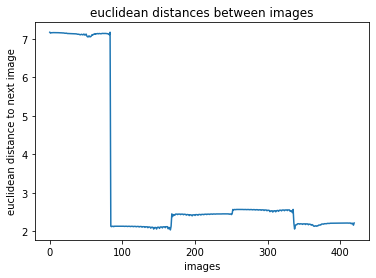

In [ ]:
image_distances = [euclidian_distance(images[i], images[i+1])for i in range(len(images)-1)]
plt.figure()
plt.title("euclidean distances between images")
plt.xlabel("images")
plt.ylabel("euclidean distance to next image")
plt.plot(image_distances)
plt.show()


### Plot Handpicked Feature Maps

In [ ]:
#edges
#feature_maps = [('block_1_project_BN',1),('block_1_project_BN',2),('block_1_project_BN',3),('block_1_project_BN',9),('block_1_project_BN',20),('block_1_project_BN',22)]
#textures
#feature_maps = [('block_3_project_BN',6),('block_3_project_BN',10),('block_3_project_BN',26),('block_4_project_BN',20),('block_5_add',1),('block_5_add',28)]
# patterns
#feature_maps = [('block_6_project_BN',1),('block_6_project_BN',7),('block_6_project_BN',59),('block_7_project_BN',3),('block_7_project_BN',17),('block_7_add',6)]
# parts
#feature_maps= [('block_11_project_BN',5),('block_11_project_BN',89),('block_12_add',30),('block_12_add', 44),('block_12_add',74),('block_12_add',25)]
#objects
#feature_maps = [('block_13_project_BN',60),('block_14_add',149),('block_14_add',3),('block_14_add',153),('block_14_add',95),('block_14_add',110)]
#classes 
feature_maps = [('pre_softmax', 385),('pre_softmax', 76),('pre_softmax', 62),('pre_softmax', 445),('pre_softmax', 468),('pre_softmax', 366)]
imgs = []
for map in feature_maps:
    path = '/content/drive/My Drive/Colab Notebooks/Bachelor Arbeit/images/'  + map[0] +  "/" + str(map[1]) + "_lucid" + ".png"
    img = np.asarray(tf.keras.preprocessing.image.load_img(path), dtype=np.float32)
    imgs.append(normalize_image(img))

<function matplotlib.pyplot.show>

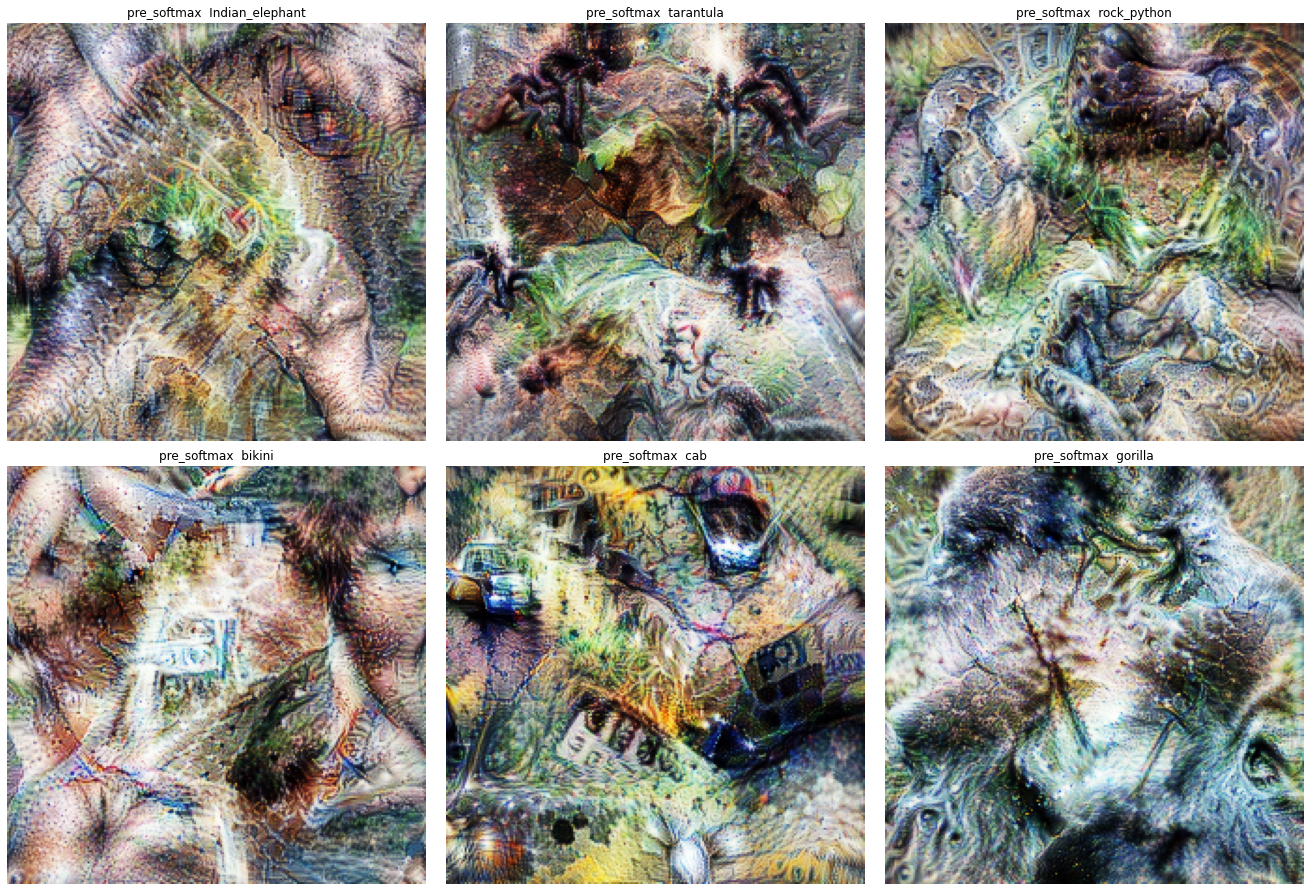

In [ ]:
fig = plt.figure(figsize = (18,12))
fig.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0.05, wspace = 0.05)
for i, img in enumerate(imgs):
    plt.subplot(2,3,i+1)
    plt.axis('off')
    # title for class logits
    plt.title(feature_maps[i][0] + "  " + class_dict[feature_maps[i][1]])
    # layer and unit
    #plt.title(feature_maps[i][0] + "  " + 'unit: ' + str(feature_maps[i][1]))
    img_show = tf.cast(255*(img + 1.0)/2.0, tf.uint8)
    plt.imshow(img_show)
plt.show

In [ ]:
logits = True
#feature_maps = [('predictions', 385),('predictions', 76),('predictions', 62),('predictions', 445),('predictions', 468),('predictions', 366)]
foldername = 'classes'
for layer, unit in feature_maps:
    
    if logits:
        model = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet', classifier_activation=None)
    else:
        model = eval(model_func)

    feature_map = model.get_layer('predictions').output[:,unit] 


    visualization_model = tf.keras.Model(
                                inputs=model.inputs, 
                                outputs=feature_map
                            )
    filename = layer + str(unit) + "_1" + ".mp4"
    save_path= r'/content/drive/My Drive/Colab Notebooks/Bachelor Arbeit/videos/' + foldername + '/' + filename
    img_path1 = '/content/drive/My Drive/Colab Notebooks/Bachelor Arbeit/images/' + layer + '/' + str(unit) + '_lucid' + '.png'


    ani, images, final_activations = animate_featuremap(visualization_model , save_path=save_path, plot=False, img_paths=[img_path1])
    print(layer,unit)

Sampling not dense enough, run NEB again with interpolations as pivots and half the steps
steps 0
Sampling not dense enough, run NEB again with interpolations as pivots and half the steps
steps 0
Sampling not dense enough, run NEB again with interpolations as pivots and half the steps
steps 0
Sampling not dense enough, run NEB again with interpolations as pivots and half the steps
steps 0
Sampling not dense enough, run NEB again with interpolations as pivots and half the steps
steps 0
pre_softmax 385
Sampling not dense enough, run NEB again with interpolations as pivots and half the steps
steps 1
Sampling not dense enough, run NEB again with interpolations as pivots and half the steps
steps 0
Sampling not dense enough, run NEB again with interpolations as pivots and half the steps
steps 0
Sampling not dense enough, run NEB again with interpolations as pivots and half the steps
steps 0
Sampling not dense enough, run NEB again with interpolations as pivots and half the steps
steps 1
pre_